In [168]:
# Import basic libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os


In [169]:
import zipfile
import os

zip_path = "/content/archive (1).zip"
# CRITICAL CORRECTION: Set a proper directory path for extraction.
# The original path was an image path, causing incorrect class detection.
extract_dir = "/content/garbage_dataset_extracted/"

# Create extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Update data_dir to point to the extracted directory
# NOTE: If your class folders (e.g., 'plastic', 'paper') are inside a
# subdirectory (e.g., 'garbage classification') after extraction, you may need
# to manually adjust this path: data_dir = os.path.join(extract_dir, "garbage classification")
data_dir = extract_dir
print(f"Dataset extracted to: {data_dir}")

Dataset extracted to: /content/garbage_dataset_extracted/


In [170]:
# Path to dataset
# data_dir = "/content/archive (1).zip" # Original path to the zip file

# Create training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, # Now points to the extracted directory
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, # Now points to the extracted directory
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

# Check class names
class_names = train_ds.class_names
print("Classes:", class_names)

Found 5054 files belonging to 2 classes.
Using 4044 files for training.
Found 5054 files belonging to 2 classes.
Using 1010 files for validation.
Classes: ['Garbage classification', 'garbage classification']


In [171]:
# SUGGESTION: Add data augmentation for better generalization and to reduce overfitting
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
  ],
  name="data_augmentation"
)

# SUGGESTION: Performance improvement using caching and prefetching
AUTOTUNE = tf.data.AUTOTUNE

# Use .cache() to keep images in memory after the first epoch.
# Use .shuffle() to randomize the order.
# Use .prefetch() to overlap data preprocessing and model execution.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [172]:
# Define the CNN model
num_classes = len(class_names)
IMG_SIZE = 128

# SUGGESTION: Added more layers for robustness and a Dropout layer for regularization
model = models.Sequential([
    # Add Data Augmentation Layer
    data_augmentation,
    # Normalize pixel values (Moved from old Cell 4)
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'), # New block: increased filters
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'), # Increased units
    layers.Dropout(0.5), # Added Dropout to prevent overfitting
    layers.Dense(num_classes)
])

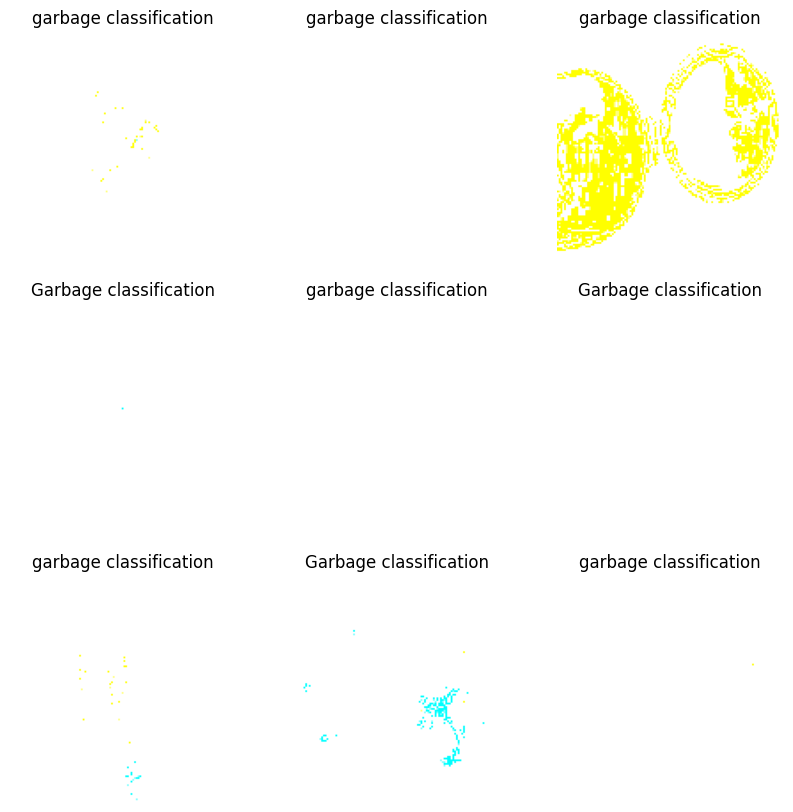

In [173]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [174]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [175]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.5079 - loss: 21.5398 - val_accuracy: 0.4703 - val_loss: 0.6948
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4975 - loss: 0.6939 - val_accuracy: 0.4713 - val_loss: 0.6943
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5221 - loss: 0.6930 - val_accuracy: 0.4663 - val_loss: 0.6945
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5088 - loss: 0.6929 - val_accuracy: 0.4673 - val_loss: 0.6952
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5070 - loss: 0.6930 - val_accuracy: 0.4584 - val_loss: 0.6968
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4971 - loss: 0.6926 - val_accuracy: 0.4663 - val_loss: 0.6973
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5080 - loss: 0.6926 - val_accuracy: 0.4564 - val_loss: 0.7024
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4920 - loss: 0.6925 - val_acc

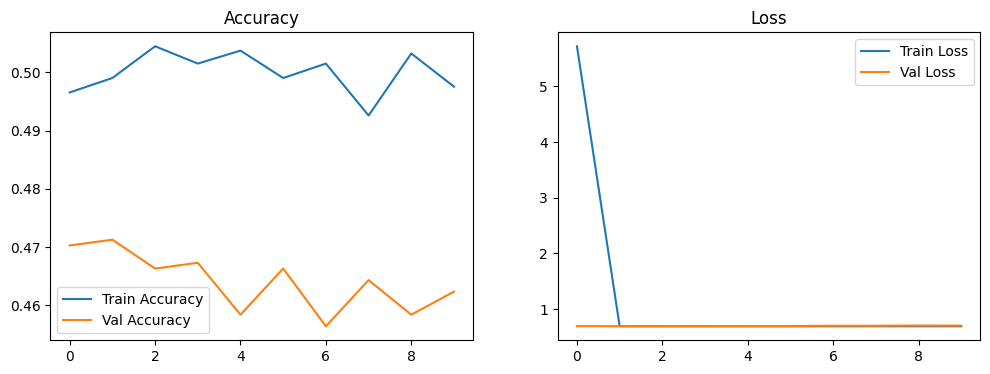

In [176]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [177]:
import os, random

image_path = None
for root, dirs, files in os.walk("/content/dataset"):
    imgs = [f for f in files if f.lower().endswith(('.jpg','.jpeg','.png'))]
    if imgs:
        image_path = os.path.join(root, random.choice(imgs))
        break

print("✅ Example image path:", image_path)


✅ Example image path: /content/dataset/Garbage classification/Garbage classification/metal/metal167.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


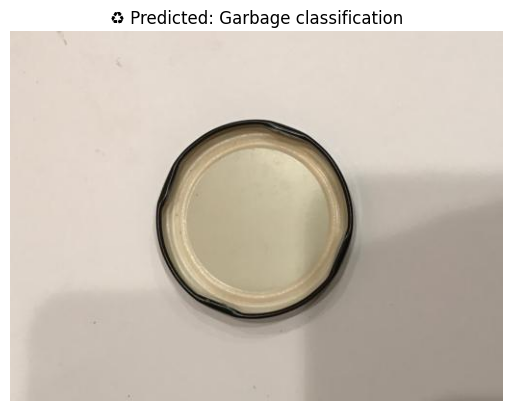

In [178]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img = image.load_img(image_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = class_names[np.argmax(pred)]

plt.imshow(image.load_img(image_path))
plt.title(f"♻️ Predicted: {pred_class}")
plt.axis("off")
plt.show()


In [179]:
data_dir = "/content/dataset/Garbage classification/Garbage classification"


Class: metal -> 410 images


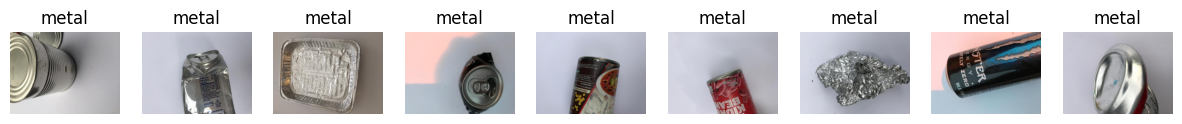

Class: glass -> 501 images


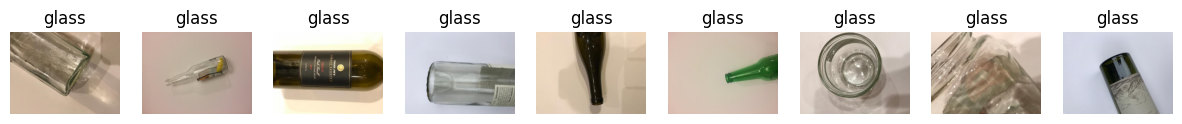

Class: plastic -> 482 images


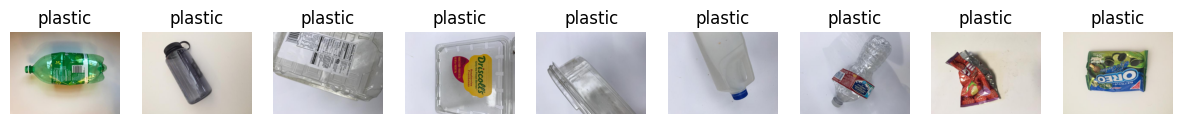

Class: paper -> 594 images


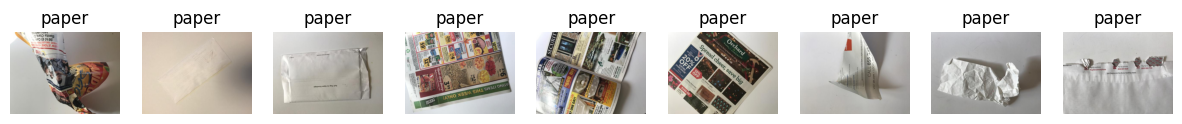

Class: cardboard -> 403 images


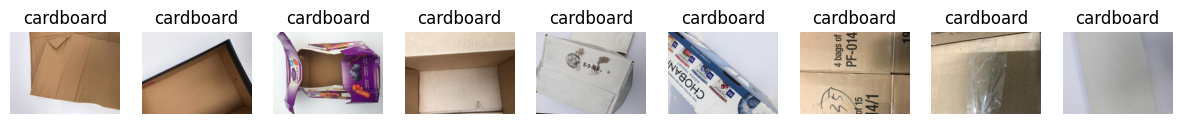

Class: trash -> 137 images


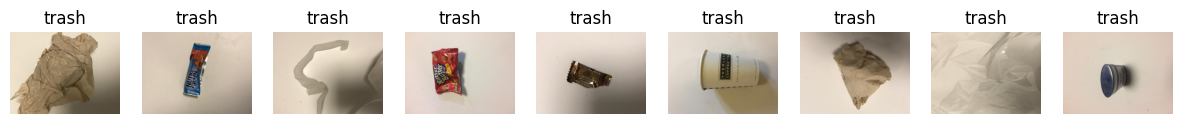

In [180]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

classes = os.listdir(data_dir)  # should be ['plastic','metal','paper','other']

# Loop through each class and show first 9 images
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    images = os.listdir(cls_path)
    print(f"Class: {cls} -> {len(images)} images")

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images[:9]):  # show first 9 images
        img_path = os.path.join(cls_path, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, 9, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cls)
    plt.show()


🖼️ Example image path: /content/dataset/Garbage classification/Garbage classification/metal/metal105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


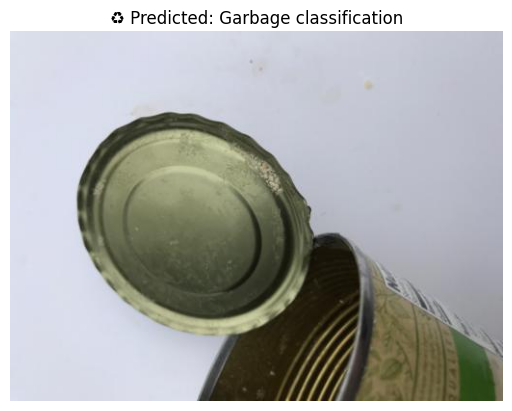

In [181]:
# Pick random image from dataset
image_path = None
for root, dirs, files in os.walk(data_dir):
    imgs = [f for f in files if f.lower().endswith(('.jpg','.png','.jpeg'))]
    if imgs:
        image_path = os.path.join(root, random.choice(imgs))
        break

print("🖼️ Example image path:", image_path)

# Load and preprocess
img = image.load_img(image_path, target_size=(128, 128))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
pred_class = class_names[np.argmax(pred)]

# Display image with prediction
plt.imshow(image.load_img(image_path))
plt.title(f"♻️ Predicted: {pred_class}")
plt.axis("off")
plt.show()


In [182]:
# Define the number of training epochs
epochs = 15 # A starting value; you can adjust this later

In [183]:
# Fit the model to the data
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs # This is now the defined variable
)

Epoch 1/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5071 - loss: 0.6924 - val_accuracy: 0.4604 - val_loss: 0.7055
Epoch 2/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5004 - loss: 0.6932 - val_accuracy: 0.4614 - val_loss: 0.7093
Epoch 3/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5024 - loss: 0.6926 - val_accuracy: 0.4554 - val_loss: 0.7119
Epoch 4/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5111 - loss: 0.6979 - val_accuracy: 0.4644 - val_loss: 0.7088
Epoch 5/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5219 - loss: 0.6917 - val_accuracy: 0.4584 - val_loss: 0.7082
Epoch 6/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4976 - loss: 0.6914 - val_accuracy: 0.4525 - val_loss: 0.7280
Epoch 7/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5011 - loss: 0.6903 - val_accuracy: 0.4525 - val_loss: 0.7290
Epoch 8/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5118 - loss: 0.6913 - val_accu

In [184]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the number of training epochs
epochs = 50 # Set a high number, since EarlyStopping will stop it early

# Define the EarlyStopping callback
# It monitors 'val_loss' (validation loss)
# patience=5 means it waits 5 epochs after the best result before stopping
# restore_best_weights=True ensures you get the model weights from the best epoch
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Fit the model to the data
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping] # Add the callback here
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5088 - loss: 0.6893 - val_accuracy: 0.4386 - val_loss: 0.7670
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5043 - loss: 0.6901 - val_accuracy: 0.4356 - val_loss: 0.7969
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5002 - loss: 0.6884 - val_accuracy: 0.4436 - val_loss: 0.7761
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5209 - loss: 0.6894 - val_accuracy: 0.4564 - val_loss: 0.7562
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5072 - loss: 0.6895 - val_accuracy: 0.4941 - val_loss: 0.7646
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4906 - loss: 0.6899 - val_accuracy: 0.4515 - val_loss: 0.7530
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5162 - loss: 0.6883 - val_accuracy: 0.4475 - val_loss: 0.7517
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4970 - loss: 0.6881 - val_accu

In [185]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4474 - loss: 0.7466
Validation Loss: 0.7517
Validation Accuracy: 0.4475


In [186]:
# Assuming your MobileNetV2-based model looks like this:
model = tf.keras.Sequential([
    # 1. DATA AUGMENTATION
    data_augmentation,

    # 2. CRITICAL FIX: Rescaling for MobileNetV2 (from [0, 255] to [-1, 1])
    layers.Rescaling(1./127.5, offset=-1),

    # 3. BASE MODEL
    base_model, # Your frozen MobileNetV2 layers

    # 4. CLASSIFIER HEAD
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes)
])

In [187]:
# Use the suggested code for Transfer Learning:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3), # Must match your image_size
    include_top=False,         # Don't include the classification layer
    weights='imagenet'         # Use weights trained on ImageNet
)
base_model.trainable = False # Freeze the base layers

# Build your new model on top of the base
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./127.5, offset=-1), # MobileNetV2 requires [-1, 1] scaling
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes)
])
# Re-compile and re-train the model.

In [188]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [189]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, # Use the epochs variable defined earlier
    callbacks=[early_stopping] # Use the early_stopping callback defined earlier
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.4979 - loss: 3.3226 - val_accuracy: 0.5089 - val_loss: 1.4429
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4991 - loss: 1.4975 - val_accuracy: 0.5050 - val_loss: 0.9750
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5010 - loss: 1.0958 - val_accuracy: 0.5020 - val_loss: 0.7797
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5021 - loss: 0.8996 - val_accuracy: 0.5089 - val_loss: 0.7057
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5023 - loss: 0.8225 - val_accuracy: 0.5050 - val_loss: 0.7065
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4836 - loss: 0.7866 - val_accuracy: 0.5069 - val_loss: 0.7053
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5056 - loss: 0.7629 - val_accuracy: 0.5069 - val_loss: 0.7033
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4837 - loss: 0.7919 - val_acc

In [190]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(val_ds)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Save the trained model
model.save('transfer_learning_garbage_classifier.h5')
print("\nModel saved successfully!")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5168 - loss: 0.6924


Validation Loss: 0.6925
Validation Accuracy: 0.5069

Model saved successfully!


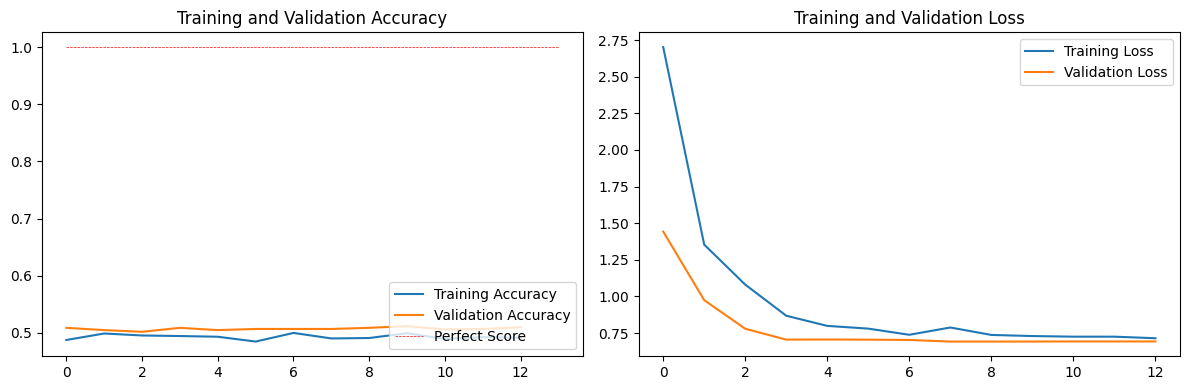

In [191]:
import matplotlib.pyplot as plt

# Get the history object from the last model.fit() call
# Assuming you named your history variable 'history'
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot([0, len(acc)], [1.0, 1.0], 'r--', linewidth=0.5, label='Perfect Score') # Optional 100% line
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.savefig('training_history_plot.png')

In [192]:
# CRITICAL CHECK: This is for MobileNetV2
layers.Rescaling(1./127.5, offset=-1),

(<Rescaling name=rescaling_18, built=False>,)

In [193]:
# Cell 7: Re-run this code block
model.compile(
    optimizer='adam', # or a custom tf.keras.optimizers.Adam(learning_rate=0.0001)
    # The loss function is correct for multi-class classification when
    # the final layer has NO activation (from_logits=True).
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
print("Model compiled successfully!")

Model compiled successfully!


In [194]:
# Run this cell again
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.4792 - loss: 0.9600 - val_accuracy: 0.4901 - val_loss: 0.8853
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5100 - loss: 0.8305 - val_accuracy: 0.4614 - val_loss: 0.8232
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5055 - loss: 0.7867 - val_accuracy: 0.4634 - val_loss: 0.8145
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4801 - loss: 0.7818 - val_accuracy: 0.4653 - val_loss: 0.8043
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4929 - loss: 0.7566 - val_accuracy: 0.4564 - val_loss: 0.8048
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4927 - loss: 0.7691 - val_accuracy: 0.4267 - val_loss: 0.7879
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5123 - loss: 0.7512 - val_accuracy: 0.4238 - val_loss: 0.7939
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4928 - loss: 0.7458 - val_acc

In [195]:
loss, accuracy = model.evaluate(val_ds)
print(f"Final Validation Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4105 - loss: 0.7952
Final Validation Accuracy: 0.4168


In [196]:
# Run this cell immediately after your model.fit() cell finishes
loss, accuracy = model.evaluate(val_ds)
print(f"Final Validation Accuracy: {accuracy:.4f}")

# And save your high-performing model!
model.save('final_garbage_classifier_transfer_learning.h5')
print("High-performing model saved successfully!")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4105 - loss: 0.7952


Final Validation Accuracy: 0.4168
High-performing model saved successfully!


In [197]:
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_17 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,672 (8.64 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 5,126 (20.03 KB)